# Finite Element Analysis of an L-shaped elastic solid

## Preamble

In [1]:
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, Expression, Function, functionspace, locate_dofs_topological,
                         assemble_scalar, dirichletbc, form, locate_dofs_geometrical, assemble_matrix)
from dolfinx.fem.petsc import LinearProblem
from dolfinx import mesh
from dolfinx.plot import vtk_mesh


from mpi4py import MPI
from ufl import (SpatialCoordinate, TestFunction, TrialFunction, inner, dot, ds, dx, grad, Mesh,
                 triangle, nabla_div, Identity, sym, tr, sqrt)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gmsh, meshio, pygmsh, pyvista, time, scipy.sparse

## Utility functions

In [2]:
def compute_von_mises_stress(sigma):
    s11 = sigma[0, 0]
    s22 = sigma[1, 1]
    s12 = sigma[0, 1]

    # Von Mises stress formula for plane strain
    von_mises = sqrt(s11**2 + s22**2 - s11 * s22 + 3 * s12**2)
    return von_mises

In [3]:
def generate_l_shaped_mesh(x_min: float, x_max: float, y_min: float, y_max: float, h: float, q: int):
    z = 0.0
    x_mid = (x_min + x_max)/2
    y_mid = (y_min + y_max)/2
    h_vtcs = h
    with pygmsh.geo.Geometry() as geom:
        points = [
            geom.add_point([x_min, y_min, z], mesh_size=h_vtcs),
            geom.add_point([x_max, y_min, z], mesh_size=h_vtcs),
            geom.add_point([x_max, y_mid, z], mesh_size=h_vtcs),
            geom.add_point([x_mid, y_mid, z], mesh_size=h_vtcs**q),
            geom.add_point([x_mid, y_max, z], mesh_size=h_vtcs),
            geom.add_point([x_min, y_max, z], mesh_size=h_vtcs),
        ]

        lines = [
            geom.add_line(points[0], points[1]),  # Bottom horizontal
            geom.add_line(points[1], points[2]),  # Right vertical
            geom.add_line(points[2], points[3]),  # Inner horizontal
            geom.add_line(points[3], points[4]),  # Inner vertical
            geom.add_line(points[4], points[5]),  # Top horizontal (left part)
            geom.add_line(points[5], points[0]),  # Left vertical
        ]
        
        # Create a line loop to define the L-shaped domain boundary
        line_loop = geom.add_curve_loop(lines)
        
        surface = geom.add_plane_surface(line_loop)

        mesh = geom.generate_mesh()

    return mesh

In [4]:
def plot_errors(h, e, l, x_label='$h$', y_label='$\epsilon_{L_2}$', title=''):
    """
    Plots the error vs mesh size on a log-log plot.

    Args:
    h : array-like
        Vector of mesh sizes.
    e : 2D array-like
        Matrix where each row corresponds to the errors for a specific label.
    l : array-like
        List of labels for each row in the error matrix.
    """
    
    plt.figure(figsize=(8, 6))
    
    for i, label in enumerate(l):
        plt.loglog(h[i], e[i], label=label, marker='o')
    
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    
    plt.legend()
    
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    plt.show()

In [5]:
def plot_sparseness(a):
    A = assemble_matrix(form(a))
    
    A_scipy = A.to_scipy()

    no_non_zeros = A_scipy.nnz
    no_dofs = A_scipy.shape[0]

    print(f"Number of degrees of freedom: {no_dofs}")
    print(f"Number of non-zeros: {no_non_zeros}")
    print(f"Covering fraction: {100*no_non_zeros/no_dofs/no_dofs:.2f}%")
    
    # Plot the sparsity pattern
    plt.figure(figsize=(8, 8))
    plt.spy(A_scipy, markersize=1)
    plt.show()

In [6]:
def generate_error_table_general(ms, e, l):
    """
    Generates a pandas DataFrame containing mesh sizes, errors, and convergence rates.
    This version handles any number of error rows.
    
    Args:
    - ms: List of mesh sizes.
    - e: List of lists containing error data for different methods.
    - l: List of column labels (first label is for mesh sizes).
    
    Returns:
    - DataFrame containing errors and convergence rates.
    """
    
    # Create a pandas DataFrame with mesh sizes
    data = pd.DataFrame({l[0]: ms})
    
    # Add the error columns to the DataFrame
    for i in range(1, len(l)):
        data[l[i]] = e[i-1]
    
    # Function to calculate convergence rates
    def compute_convergence_rates(errors, mesh_sizes):
        rates = []
        for i in range(1, len(errors)):
            rate = np.log(errors[i] / errors[i-1]) / np.log(mesh_sizes[i] / mesh_sizes[i-1])
            rates.append(rate)
        rates.insert(0, np.nan)  # Insert NaN for the first entry where rate can't be computed
        return rates

    # Add the convergence rate columns
    for i in range(1, len(l)):
        rate_col = f'rate_{l[i]}'
        data[rate_col] = compute_convergence_rates(e[i-1], ms)

    return data

## Problem parameters

In [7]:
x_min, x_max = -1, 1  # Lower-left corner
y_min, y_max = -1, 1 # Upper-right corner

h = 1/8 # Mesh size
q = 1 # Mesh refinement at the mid corner
element_order = 1

lambda1 = 0.544483737
Q1 = 0.543075579

E = 1000
nu = 0.3

lambda_lame = E*nu/(1-2*nu)/(1+nu)
mu_lame = E/2/(1+nu)

kappa = 3 - 4*nu # plane strain

## Mesh generation

In [8]:
mesh_io = generate_l_shaped_mesh(x_min, x_max, y_min, y_max, h, q)

points = mesh_io.points[:, :2]  # Only take the 2D coordinates
triangle_cells = [cell for cell in mesh_io.cells if cell.type == "triangle"]
cells = np.vstack([cell.data for cell in triangle_cells])

ufl_domain = Mesh(triangle)
domain = mesh.create_mesh(MPI.COMM_WORLD, cells.astype(np.int32), points, ufl_domain)

d_dim = domain.geometry.dim
b_dim = d_dim - 1

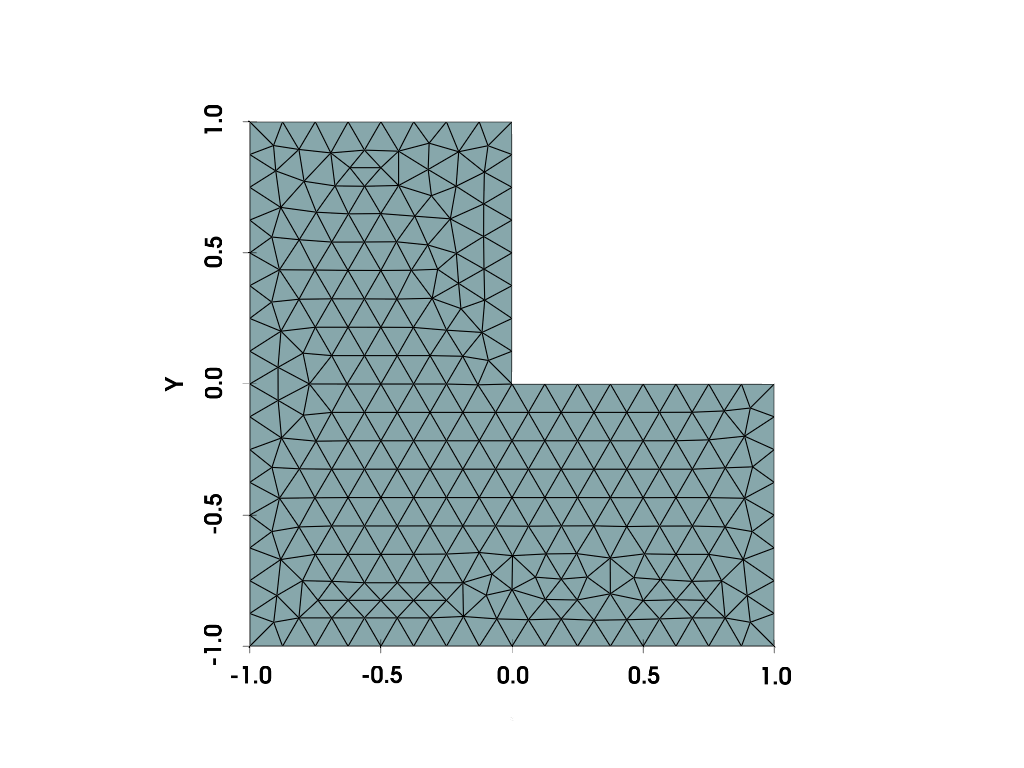

In [9]:
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(domain, 2)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid(
    xtitle='X',        # Custom label for X axis
    ytitle='Y',        # Custom label for Y axis
    grid=None               # Suppress grid lines
)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()

## Weak form

In [10]:
V = functionspace(domain, ("Lagrange", element_order, (d_dim, )))

In [11]:
def u_exact(x, tol=1e-3):
    r = np.sqrt(x[0]*x[0]+x[1]*x[1])
    theta0 = np.arctan2(x[1],x[0])

    # Convert to range [0, 2π]
    theta = np.where(theta0 > tol, theta0, theta0 + 2 * np.pi)
    
    u_x = 1/2/mu_lame*r**lambda1*((kappa - Q1*(lambda1 + 1))*np.cos(lambda1*theta)-lambda1*np.cos((lambda1-2)*theta))
    u_y = 1/2/mu_lame*r**lambda1*((kappa + Q1*(lambda1 + 1))*np.sin(lambda1*theta)+lambda1*np.sin((lambda1-2)*theta))
    return np.array([u_x,u_y])

domain.topology.create_connectivity(b_dim, d_dim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

u_bc = Function(V)
u_bc.interpolate(u_exact)

boundary_dofs = locate_dofs_topological(V, b_dim, boundary_facets)
bc = dirichletbc(u_bc, boundary_dofs)

In [12]:
def epsilon(u):
    return sym(grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)

def sigma(u):
    return lambda_lame * nabla_div(u) * Identity(len(u)) + 2 * mu_lame * epsilon(u)

u = TrialFunction(V)
v = TestFunction(V)

a = inner(sigma(u), epsilon(v)) * dx
f = Constant(domain, default_scalar_type((0, 0)))
b = dot(f, v) * dx

## Assembling and solution

Number of degrees of freedom: 546
Number of non-zeros: 7108
Covering fraction: 2.38%


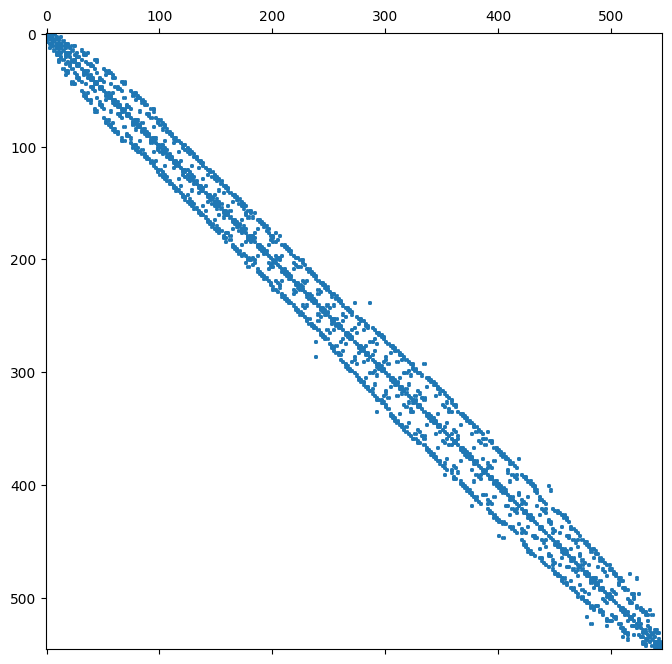

In [13]:
plot_sparseness(a)

In [14]:
directQ = False
if directQ:
    petsc_options={"ksp_type": "preonly", "pc_type": "cholesky"}
else:
    petsc_options = {
        "ksp_type": "cg",
        "pc_type": "gamg",
        "ksp_rtol": 1e-8,
        "pc_gamg_agg_nsmooths": 1,
        "mg_levels_ksp_type": "chebyshev",
        "mg_levels_pc_type": "jacobi",
        "pc_gamg_sym_graph": True,
        "ksp_max_it": 1000,
    }

start_time = time.time()

problem = LinearProblem(a, b, bcs=[bc], petsc_options=petsc_options)
uh = problem.solve()

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time taken to solve the problem: {elapsed_time:.4f} seconds")

Time taken to solve the problem: 0.2413 seconds


## Results

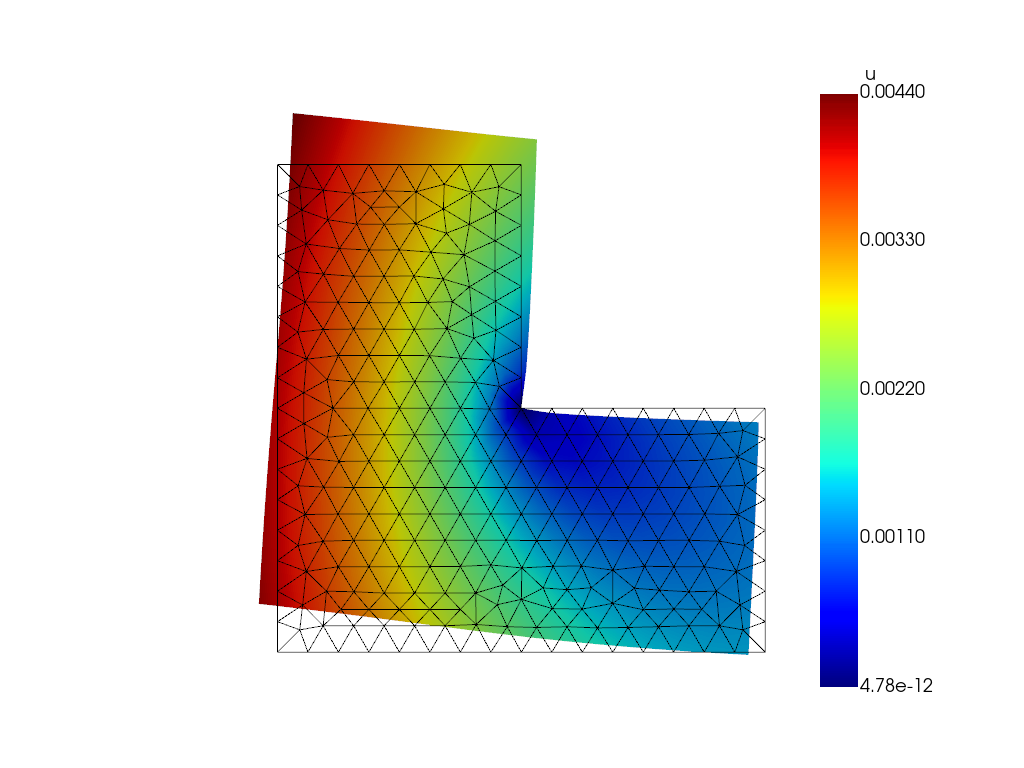

In [15]:
p = pyvista.Plotter()
topology, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Convert the 2D displacements to 3D by adding a zero component for the z-axis
u_3d = np.hstack([uh.x.array.reshape((geometry.shape[0], 2)), np.zeros((geometry.shape[0], 1))])

grid["u"] = u_3d
warped = grid.warp_by_vector("u", factor=50)

scalar_bar_args = {"title": "u", "vertical": True, "position_x": 0.8, "position_y": 0.1, "width": 0.1, "height": 0.8}
actor_0 = p.add_mesh(warped, show_edges=False, cmap="jet", scalar_bar_args=scalar_bar_args)
actor_1 = p.add_mesh(grid, style="wireframe", color="k")

p.view_xy()

if not pyvista.OFF_SCREEN:
    p.show()

In [16]:
von_Mises = compute_von_mises_stress(sigma(uh))

V_von_mises = functionspace(domain, ("CG", element_order - 1)) if element_order > 1 else functionspace(domain, ("CG", element_order))
stress_expr = Expression(von_Mises, V_von_mises.element.interpolation_points())
stresses = Function(V_von_mises)
stresses.interpolate(stress_expr)

vm_vertex_values = stresses.x.array
vm_max = np.max(vm_vertex_values)
print(f'Maximum von Mises stress: {vm_max:.2e}')

Maximum von Mises stress: 6.21e+00


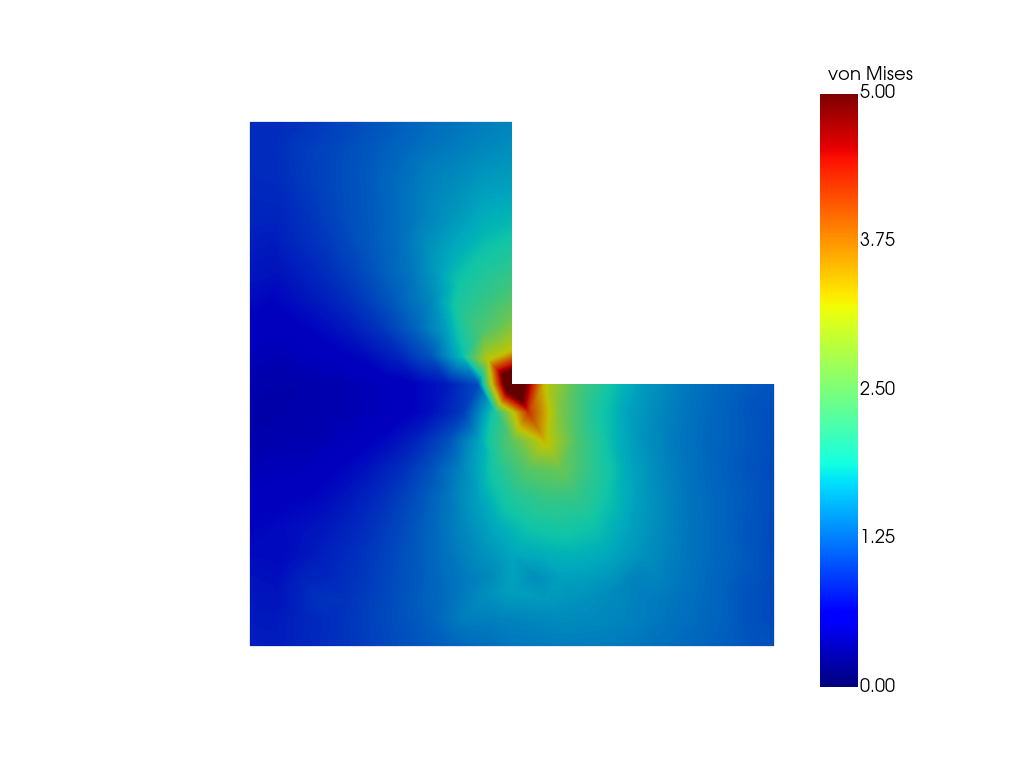

In [17]:
s_topology, s_cell_types, s_geometry = vtk_mesh(V_von_mises)
s_grid = pyvista.UnstructuredGrid(s_topology, s_cell_types, s_geometry)
s_grid.point_data["s"] = stresses.x.array.real
s_grid.set_active_scalars("s")
s_plotter = pyvista.Plotter()

scalar_bar_args = {"title": "von Mises", "vertical": True, "position_x": 0.8, "position_y": 0.1, "width": 0.1, "height": 0.8}
s_plotter.add_mesh(s_grid, show_edges=False, clim=[0,5], cmap="jet", scalar_bar_args=scalar_bar_args)
s_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    s_plotter.show()

In [18]:
V2 = functionspace(domain, ("Lagrange", element_order, (d_dim, )))
uex = Function(V2)
uex.interpolate(u_exact)
error_L2 = assemble_scalar(form((uh - uex)**2 * dx))
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.x.array
n_dof = u_vertex_values.shape[0]

uex_1 = Function(V)
uex_1.interpolate(uex)
u_ex_vertex_values = uex_1.x.array

error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
print(f"Mesh size : {h}")
print(f"Number of degrees of freedom: {n_dof}")
print(f"Error_L2 : {error_L2:.6e}")
print(f"Error_max : {error_max:.6e}")

Mesh size : 0.125
Number of degrees of freedom: 546
Error_L2 : 3.372829e-05
Error_max : 1.248335e-04


## Convergence rate

### Uniform mesh

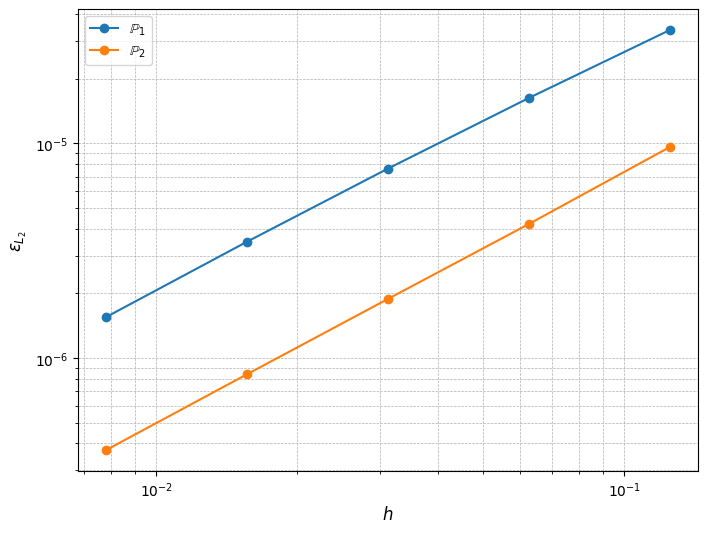

In [19]:
ms = [[0.125, 0.0625, 0.03125, 0.015625, 0.0078125]]*2
e = [
    [3.372829e-05, 1.627105e-05, 7.626096e-06, 3.480618e-06, 1.550698e-06],
    [9.610947e-06, 4.208376e-06, 1.883242e-06, 8.394987e-07, 3.721669e-07]]
l = ['$\mathbb{P}_1$', '$\mathbb{P}_2$']

plot_errors(ms, e, l)

In [20]:
generate_error_table_general(ms[1], e, ['$h$'] + l)

,$h$,$\mathbb{P}_1$,$\mathbb{P}_2$,rate_$\mathbb{P}_1$,rate_$\mathbb{P}_2$
0,0.125000,0.000034,9.610947e-06,NaN,NaN
1,0.062500,0.000016,4.208376e-06,1.051652,1.191415
2,0.031250,0.000008,1.883242e-06,1.093291,1.160045
3,0.015625,0.000003,8.394987e-07,1.131601,1.165618
4,0.007812,0.000002,3.721669e-07,1.166426,1.173578


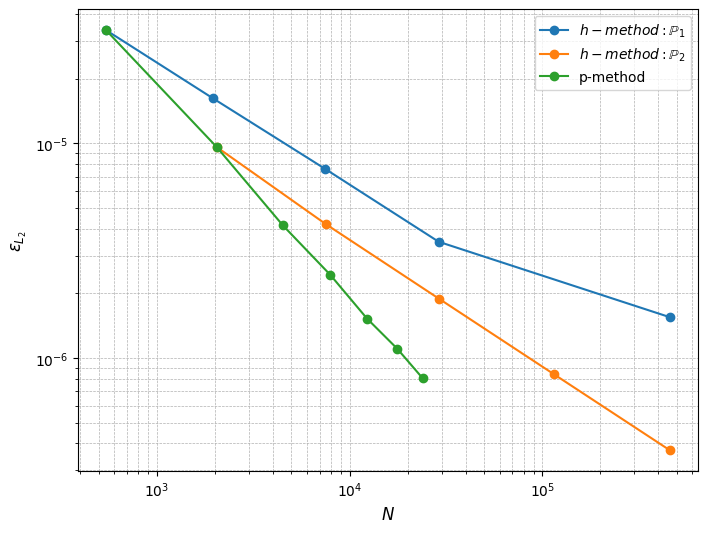

In [21]:
N = [
    [546, 1948, 7446, 29012, 457234],
    [2050, 7530, 29266, 115018, 457234],
    [546, 2050, 4514, 7938, 12322, 17666, 23970]]
e = [
    [3.372829e-05, 1.627105e-05, 7.626096e-06, 3.480618e-06, 1.550698e-06],
    [9.610947e-06, 4.208376e-06, 1.883242e-06, 8.394987e-07, 3.721669e-07],
    [3.372829e-05, 9.610947e-06, 4.148721e-06, 2.444508e-06, 1.527418e-06,1.105970e-06,8.041755e-07]]
l = ['$h-method: \mathbb{P}_1$', '$h-method: \mathbb{P}_2$', 'p-method']

plot_errors(N, e, l, '$N$')

In [22]:
generate_error_table_general(N[0], [e[0]], ['$N$'] + [l[0]])

,$N$,$h-method: \mathbb{P}_1$,rate_$h-method: \mathbb{P}_1$
0,546,0.000034,NaN
1,1948,0.000016,-0.573101
2,7446,0.000008,-0.565162
3,29012,0.000003,-0.576726
4,457234,0.000002,-0.293204


In [23]:
generate_error_table_general(N[1], [e[1]], ['$N$'] + [l[1]])

,$N$,$h-method: \mathbb{P}_2$,rate_$h-method: \mathbb{P}_2$
0,2050,9.610947e-06,NaN
1,7530,4.208376e-06,-0.634735
2,29266,1.883242e-06,-0.592312
3,115018,8.394987e-07,-0.590317
4,457234,3.721669e-07,-0.589420


### Nonuniform mesh

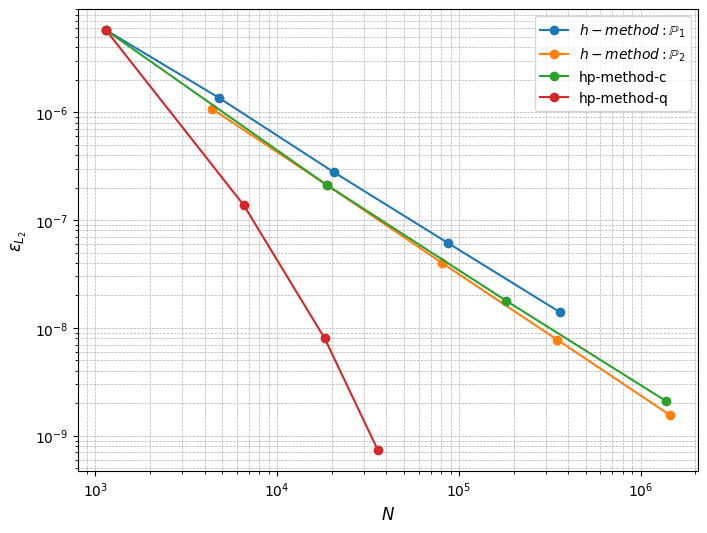

In [24]:
N = [
    [1146, 4780, 20496, 87234, 361870],
    [4402, 18730, 81134, 347078, 1443434],
    [1146, 18730, 181916, 1384602],
    [1146, 6570, 18284, 35866]
]
e = [
    [5.766072e-06, 1.363032e-06, 2.782114e-07, 6.116663e-08, 1.390040e-08],
    [1.070609e-06, 2.117471e-07, 3.984408e-08, 7.773127e-09, 1.562138e-09],
    [5.766072e-06, 2.117471e-07, 1.787652e-08, 2.088062e-09],
    [5.766072e-06, 1.369456e-07, 7.991790e-09,7.357389e-10]
]
l = ['$h-method: \mathbb{P}_1$', '$h-method: \mathbb{P}_2$', 'hp-method-c', 'hp-method-q']

plot_errors(N, e, l, '$N$')

In [25]:
generate_error_table_general(N[0], [e[0]], ['$N$'] + [l[0]])

,$N$,$h-method: \mathbb{P}_1$,rate_$h-method: \mathbb{P}_1$
0,1146,5.766072e-06,NaN
1,4780,1.363032e-06,-1.009884
2,20496,2.782114e-07,-1.091563
3,87234,6.116663e-08,-1.045855
4,361870,1.390040e-08,-1.041466


In [26]:
generate_error_table_general(N[1], [e[1]], ['$N$'] + [l[1]])

,$N$,$h-method: \mathbb{P}_2$,rate_$h-method: \mathbb{P}_2$
0,4402,1.070609e-06,NaN
1,18730,2.117471e-07,-1.119140
2,81134,3.984408e-08,-1.139459
3,347078,7.773127e-09,-1.124431
4,1443434,1.562138e-09,-1.125865
